# Installation

In [ ]:
! apt-get install openjdk-8-jdk-headless -qq > /dev/null
# ! wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
! cp drive/MyDrive/Midterm_BigData/spark-3.5.4-bin-hadoop3.tgz .
! tar xf spark-3.5.4-bin-hadoop3.tgz
! pip install -q findspark
! pip install memory_profiler

In [ ]:
! du -sh spark-3.5.4-bin-hadoop3.tgz

383M	spark-3.5.4-bin-hadoop3.tgz


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [ ]:
! echo $JAVA_HOME

/usr/lib/jvm/java-8-openjdk-amd64


In [ ]:
! echo $SPARK_HOME

/content/spark-3.5.4-bin-hadoop3


In [ ]:
import findspark
findspark.init()

# Import necessary Library

In [ ]:
from pyspark.sql import SparkSession,DataFrame,Window, functions as F
from pyspark.sql.types import ArrayType, StringType, MapType, FloatType
from pyspark.ml.feature import MinHashLSH, FeatureHasher
from itertools import combinations
import time
import matplotlib.pyplot as plt
from memory_profiler import memory_usage

# Load Dataset && Preprocessing

In [ ]:
spark = SparkSession.builder\
                    .appName("Midterm_BigData")\
                    .getOrCreate()

In [ ]:
df = spark.read.csv('./drive/MyDrive/Midterm_BigData/baskets.csv',header=True)
df.printSchema()

root
 |-- Member_number: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- itemDescription: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)
 |-- day: string (nullable = true)
 |-- day_of_week: string (nullable = true)



In [ ]:
df.show(20)
print(df.count())

+-------------+----------+--------------------+----+-----+---+-----------+
|Member_number|      Date|     itemDescription|year|month|day|day_of_week|
+-------------+----------+--------------------+----+-----+---+-----------+
|         1249|01/01/2014|        citrus fruit|2014|    1|  1|          2|
|         1249|01/01/2014|              coffee|2014|    1|  1|          2|
|         1381|01/01/2014|                curd|2014|    1|  1|          2|
|         1381|01/01/2014|                soda|2014|    1|  1|          2|
|         1440|01/01/2014|    other vegetables|2014|    1|  1|          2|
|         1440|01/01/2014|              yogurt|2014|    1|  1|          2|
|         1659|01/01/2014| specialty chocolate|2014|    1|  1|          2|
|         1659|01/01/2014|   frozen vegetables|2014|    1|  1|          2|
|         1789|01/01/2014|      hamburger meat|2014|    1|  1|          2|
|         1789|01/01/2014|             candles|2014|    1|  1|          2|
|         1922|01/01/2014

In [ ]:
df = df.dropDuplicates()
print(df.count())

38006


In [ ]:
def convertToBaskets(dataframe:DataFrame)->DataFrame:
  '''
  Objective:  Convert dataframe to formatted baskets dataframe
  Input: dataframe
  Output: baskets dataframe
  '''
  formatted_df = dataframe.withColumn(
      "itemDescription",
      F.trim(F.col("itemDescription"))
  )
  # Group member and date as a basket with respective items
  df = formatted_df\
      .groupBy("Member_number","Date")\
      .agg(F.collect_list("itemDescription").alias("Items"))

  windowSpec = Window.orderBy("Member_number","Date")

  #Mark a basket_id
  baskets = df.withColumn("basket_id",F.row_number().over(windowSpec))

  return baskets.select('basket_id','Items','Member_number','Date')

In [ ]:
dataframe = convertToBaskets(df)
dataframe.show(10,truncate=False)

+---------+--------------------------------------------------+-------------+----------+
|basket_id|Items                                             |Member_number|Date      |
+---------+--------------------------------------------------+-------------+----------+
|1        |[whole milk, semi-finished bread, sausage, yogurt]|1000         |15/03/2015|
|2        |[salty snack, whole milk, pastry]                 |1000         |24/06/2014|
|3        |[canned beer, misc. beverages]                    |1000         |24/07/2015|
|4        |[sausage, hygiene articles]                       |1000         |25/11/2015|
|5        |[soda, pickled vegetables]                        |1000         |27/05/2015|
|6        |[sausage, whole milk, rolls/buns]                 |1001         |02/07/2014|
|7        |[frankfurter, curd]                               |1001         |05/02/2015|
|8        |[soda, whole milk]                                |1001         |12/12/2014|
|9        |[white bread, beef]  

# TASK 2: PCY Algorithm

## Design algorithm

In [ ]:
class PCY_Algorithm:

  '''Constructor'''
  def __init__(self, minSupport:float,
               minConfidence:float,num_bucket:int= None):

    '''Initiate some values for model'''

    #Data
    self.support_threshold:int = minSupport #min support
    self.confidence_threshold:float = minConfidence #min confidence
    self.size:int = 0
    self.num_bucket = num_bucket

    #DataFrame
    self.baskets:DataFrame = None
    self.frequentBucket:dict = None
    self.freqItem = None
    self.freqPair = None
    self.freqItemsets = None
    self.associationRules = None

  '''Getters'''
  def set_min_support(self,min_support):
    self.support_threshold = min_support

  def set_min_confidence(self,min_confidence):
    self.confidence_threshold = min_confidence


  def pass1(self,freqItems,freqBuckets,numBucket)->None:
    '''
    Objective:
      Build a list of frequent item (frequent 1-itemsets)
      &&
      Construct hashtable
    '''
    # Construct list of frequent item
    df_exploded = self.baskets.select(F.explode("Items").alias("Items"))

    item_counts = df_exploded\
                  .groupBy("Items")\
                  .agg(F.count("Items").alias("freq"))

    self.freqItem = item_counts\
                        .filter(F.col("freq")/self.size >= self.support_threshold)

    def create_pairs(items):
      '''
      Objective: Generate pairs of items
      '''
      unique_items = list(set(items))
      return [list(pair) for pair in combinations(unique_items, 2)]

    #define a user defined function
    pair_udf = F.udf(create_pairs, ArrayType(ArrayType(StringType())))

    #Construct hash table
    df_pairs = self.baskets.select(F.explode(pair_udf("Items")).alias("pair"))\
    .withColumn("bucket", F.hash(F.col("pair")))


    bucket_counts = df_pairs\
                    .groupBy("bucket")\
                    .agg(F.count("bucket").alias("count"))\
                    .filter(F.col("count")/self.size >= self.support_threshold)

    # create a temporary bucket dict dataframe
    bucket_dict = dict(
        bucket_counts\
        .rdd.
        map(lambda row: (row['bucket'],row['count']))\
        .collect()
        )

    #Create a set of frequent items
    frequent_items = dict(
        self.freqItem\
        .rdd\
        .map(lambda row: (row['Items'], row['freq']))\
        .collect()
    )

    # ''' Create Broadcast variable ''''
    freqItems = spark.sparkContext.broadcast(frequent_items)
    freqBuckets = spark.sparkContext.broadcast(bucket_dict)
    numBucket = spark.sparkContext.broadcast(self.num_bucket)

    return freqItems,freqBuckets,numBucket



  def pass2(self, freqItems,freqBuckets,numBucket)->None:
    '''
    Objective: Find frequent 2-itemsets
    '''

    frequent_items = freqItems.value
    bucket_map = freqBuckets.value
    num_bucket = numBucket.value

    def create_candidate_pairs(items, frequent_items):
      '''
      Generate candidate pairs based on frequent items.
      '''
      unique_items = sorted(set(items))
      return [list(pair) for pair in combinations(unique_items, 2)
              if pair[0] in frequent_items and pair[1] in frequent_items]


    candidate_udf = F.udf(lambda items:
                          create_candidate_pairs(items, frequent_items),
                          ArrayType(ArrayType(StringType()))
                          )


    df_pairs = self.baskets.select(
        F.explode(candidate_udf("Items"))\
        .alias("pair")
        ) \
        .withColumn(
            "bucket",
            F.hash(F.col("pair"))
            )

    # Grouped pairs and count as frequency
    pair_counts = df_pairs\
                  .groupBy("pair")\
                  .agg(F.count("pair").alias("freq"))


    #Filter all well-qualified pairs
    frequent_pairs = pair_counts\
                    .filter(F.col("freq") / self.size >= self.support_threshold)


    self.freqPair = frequent_pairs
    self.freqItem = self.freqItem.withColumn("Items",F.array("Items"))
    self.freqItemsets = self.freqItem.union(self.freqPair)


  def gen_association_rules(self,freqItems:dict)->DataFrame:
    '''
    Objective: Generate association rules from frequent 2-itemsets
    Input: freqItems: dict of frequent items
    Output: DataFrame with Columns: antecedent, consequent, support, confidence
    '''

    size = spark.sparkContext.broadcast(self.size)

    # split frequent 2-itemset
    rules = self.freqPair.select(
        F.col("pair")[0].alias("item1"),
        F.col("pair")[1].alias("item2"),
        F.col("freq")
    )
    # rules.show(100000,truncate=False)
    def calc_confidence(item1, item2, freq):
        support_ab = freq
        support_a = freqItems.value.get(item1, 0)
        support_b = freqItems.value.get(item2, 0)
        conf_ab = support_ab / support_a if support_a > 0 else 0
        conf_ba = support_ab / support_b if support_b > 0 else 0
        return [conf_ab, conf_ba]

    confidence_udf = F.udf(calc_confidence, ArrayType(FloatType()))

    rules_with_conf = rules.withColumn("confidences", confidence_udf("item1", "item2", "freq"))

    # Generate A -> B rules
    rules_ab = rules_with_conf.select(
        F.col("item1").alias("antecedent"),
        F.col("item2").alias("consequent"),
        F.col("confidences")[0].alias("confidence"),
        (F.col("freq") / self.size).alias("support")
    )

    # Generate B -> A rules
    rules_ba = rules_with_conf.select(
        F.col("item2").alias("antecedent"),
        F.col("item1").alias("consequent"),
        F.col("confidences")[1].alias("confidence"),
        (F.col("freq") / self.size).alias("support")
    )

    # Merge and filter based on confidence threshold
    all_rules = rules_ab.union(rules_ba)
    self.associationRules = all_rules.filter(F.col("confidence") >= self.confidence_threshold)

    return self.associationRules

  def fit(self, data:DataFrame)->None:

    self.baskets = data
    self.size:int = self.baskets.count() if self.baskets is not None else 0
    self.num_bucket = int(10**(len(str(self.size))+1)) if self.num_bucket is None else self.num_bucket


    '''Create a broadcast variable'''
    freqItems = None
    freqBuckets = None
    numBucket = None

    freqItems, freqBuckets, numBucket = self.pass1(freqItems,freqBuckets,numBucket)
    self.pass2(freqItems,freqBuckets,numBucket)
    self.gen_association_rules(freqItems)



In [ ]:
pcy = PCY_Algorithm(minSupport=0.0005,minConfidence=0.01)

In [ ]:
#Show 100 first baskets
data = dataframe.select("Items")
pcy.fit(data)

In [ ]:
print(pcy.size)

14963


In [ ]:
pcy.freqItem.sort(F.desc("freq")).show(10,truncate=False)

+------------------+----+
|Items             |freq|
+------------------+----+
|[whole milk]      |2363|
|[other vegetables]|1827|
|[rolls/buns]      |1646|
|[soda]            |1453|
|[yogurt]          |1285|
|[root vegetables] |1041|
|[tropical fruit]  |1014|
|[bottled water]   |908 |
|[sausage]         |903 |
|[citrus fruit]    |795 |
+------------------+----+
only showing top 10 rows



In [ ]:
pcy.freqPair.sort(F.desc("freq")).show(10,truncate=False)

+------------------------------+----+
|pair                          |freq|
+------------------------------+----+
|[other vegetables, whole milk]|222 |
|[rolls/buns, whole milk]      |209 |
|[soda, whole milk]            |174 |
|[whole milk, yogurt]          |167 |
|[other vegetables, rolls/buns]|158 |
|[other vegetables, soda]      |145 |
|[sausage, whole milk]         |134 |
|[tropical fruit, whole milk]  |123 |
|[other vegetables, yogurt]    |121 |
|[rolls/buns, soda]            |121 |
+------------------------------+----+
only showing top 10 rows



In [ ]:
pcy.freqItemsets.sort(F.desc("freq")).show(10,truncate=False)

+------------------+----+
|Items             |freq|
+------------------+----+
|[whole milk]      |2363|
|[other vegetables]|1827|
|[rolls/buns]      |1646|
|[soda]            |1453|
|[yogurt]          |1285|
|[root vegetables] |1041|
|[tropical fruit]  |1014|
|[bottled water]   |908 |
|[sausage]         |903 |
|[citrus fruit]    |795 |
+------------------+----+
only showing top 10 rows



In [ ]:
pcy.associationRules.sort(F.desc("confidence")).show(1000,truncate=False)

+-------------------------+------------------------+-----------+---------------------+
|antecedent               |consequent              |confidence |support              |
+-------------------------+------------------------+-----------+---------------------+
|brandy                   |whole milk              |0.34210527 |8.688097306689834E-4 |
|softener                 |whole milk              |0.29268292 |8.019782129252155E-4 |
|artif. sweetener         |whole milk              |0.27586207 |5.346521419501437E-4 |
|house keeping products   |whole milk              |0.24444444 |7.351466951814476E-4 |
|spices                   |soda                    |0.225      |6.014836596939117E-4 |
|finished products        |whole milk              |0.203125   |8.688097306689834E-4 |
|dish cleaner             |whole milk              |0.1780822  |8.688097306689834E-4 |
|semi-finished bread      |whole milk              |0.17605634 |0.001670787943594199 |
|canned vegetables        |whole milk      

##Test


In [ ]:
from pyspark.ml.fpm import FPGrowth
data = data.withColumnRenamed("Items","items")

In [ ]:
fp = FPGrowth(minSupport=0.0005, minConfidence=0.01)

fpm = fp.fit(data)

In [ ]:
fpm.freqItemsets.sort(F.desc("freq")).show(10,truncate=False)

+------------------+----+
|items             |freq|
+------------------+----+
|[whole milk]      |2363|
|[other vegetables]|1827|
|[rolls/buns]      |1646|
|[soda]            |1453|
|[yogurt]          |1285|
|[root vegetables] |1041|
|[tropical fruit]  |1014|
|[bottled water]   |908 |
|[sausage]         |903 |
|[citrus fruit]    |795 |
+------------------+----+
only showing top 10 rows



In [ ]:
fpm.associationRules.sort(F.desc("confidence")).show(10,truncate=False)

+-------------------------+------------------+-------------------+------------------+---------------------+
|antecedent               |consequent        |confidence         |lift              |support              |
+-------------------------+------------------+-------------------+------------------+---------------------+
|[pork, sausage]          |[whole milk]      |0.391304347826087  |2.4778192791035716|6.014836596939117E-4 |
|[brandy]                 |[whole milk]      |0.34210526315789475|2.1662805978127717|8.688097306689834E-4 |
|[softener]               |[whole milk]      |0.2926829268292683 |1.8533282412807202|8.019782129252155E-4 |
|[white bread, rolls/buns]|[whole milk]      |0.28125            |1.780932606855692 |6.014836596939117E-4 |
|[artif. sweetener]       |[whole milk]      |0.27586206896551724|1.7468151239657363|5.346521419501437E-4 |
|[shopping bags, sausage] |[other vegetables]|0.27586206896551724|2.2592907158900024|5.346521419501437E-4 |
|[sausage, yogurt]        |[

## Visualization

Testing with minSupport=1e-06, minConfidence=0.001
PCY Algorithm took 4.09 seconds
FPGrowth took 1.13 seconds
Testing with minSupport=1e-05, minConfidence=0.001
PCY Algorithm took 3.47 seconds
FPGrowth took 0.97 seconds
Testing with minSupport=0.0001, minConfidence=0.001
PCY Algorithm took 5.17 seconds
FPGrowth took 0.97 seconds
Testing with minSupport=0.001, minConfidence=0.001
PCY Algorithm took 3.28 seconds
FPGrowth took 0.97 seconds
Testing with minSupport=0.01, minConfidence=0.001
PCY Algorithm took 2.89 seconds
FPGrowth took 0.86 seconds
Testing with minSupport=0.1, minConfidence=0.001
PCY Algorithm took 4.14 seconds
FPGrowth took 1.43 seconds


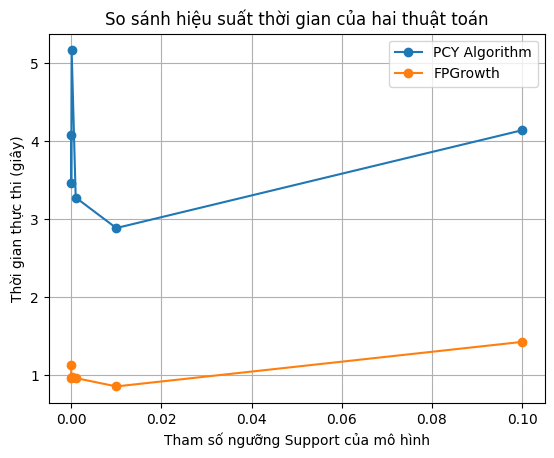

In [ ]:
'''Visualize time of 2 algorithms'''
minSupports = [
  0.000001,
  0.00001,
  0.0001,
  0.001,
  0.01,
  0.1
]
minConfidence = 0.001
times_pcy = []
times_fpm = []

for minSupport in minSupports:
    print(f"Testing with minSupport={minSupport}, minConfidence={minConfidence}")

    '''PCY Algorithm'''
    start = time.time()
    pcy = PCY_Algorithm(minSupport=minSupport, minConfidence=minConfidence)
    pcy.fit(data)
    end = time.time()
    times_pcy.append(end - start)
    print(f"PCY Algorithm took {end - start:.2f} seconds")

    '''FPGrowth'''
    start = time.time()
    fp = FPGrowth(minSupport=minSupport, minConfidence=minConfidence)
    fpm = fp.fit(data)
    end = time.time()
    times_fpm.append(end - start)
    print(f"FPGrowth took {end - start:.2f} seconds")

# Plotting the results
plt.plot(minSupports, times_pcy, label="PCY Algorithm", marker='o')
plt.plot(minSupports, times_fpm, label="FPGrowth", marker='o')
plt.xlabel("Tham số ngưỡng Support của mô hình")
plt.ylabel("Thời gian thực thi (giây)")
plt.title("So sánh hiệu suất thời gian của hai thuật toán")
plt.legend()
plt.grid(True)
plt.show()

1. PCY Algorithm:
- Thời gian: PCY cải thiện thuật toán Apriori bằng cách sử dụng bảng băm để giảm số lượng cặp ứng viên cần kiểm tra. Điều này giúp giảm thời gian xử lý, đặc biệt khi dữ liệu lớn2.
2. FP-Growth Algorithm:
- Thời gian: FP-Growth thường nhanh hơn PCY vì nó không cần tạo ra các cặp ứng viên. Thay vào đó, nó xây dựng một cây FP (Frequent Pattern) để lưu trữ dữ liệu và khai thác các mẫu thường xuyên trực tiếp từ cây này4.

Testing with minSupport=1e-06, minConfidence=0.001
Testing with minSupport=1e-05, minConfidence=0.001
Testing with minSupport=0.0001, minConfidence=0.001
Testing with minSupport=0.001, minConfidence=0.001
Testing with minSupport=0.01, minConfidence=0.001
Testing with minSupport=0.1, minConfidence=0.001


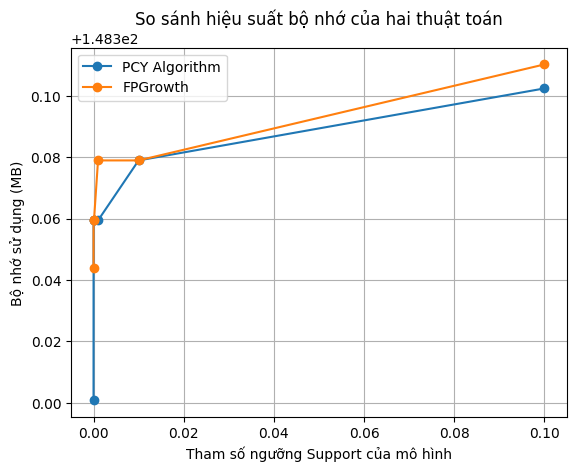

In [ ]:
'''Visualize memory usage of 2 algorithms'''
mem_usages_pcy = []
mem_usages_fpm = []

for minSupport in minSupports:
    print(f"Testing with minSupport={minSupport}, minConfidence={minConfidence}")

    '''PCY Algorithm'''
    pcy = PCY_Algorithm(minSupport=minSupport, minConfidence=minConfidence)
    mem_usage_pcy = memory_usage((pcy.fit, (data,)))
    mem_usages_pcy.append(max(mem_usage_pcy))

    '''FPGrowth'''
    fp = FPGrowth(minSupport=minSupport, minConfidence=minConfidence)
    mem_usage_fpm = memory_usage((fp.fit, (data,)))
    mem_usages_fpm.append(max(mem_usage_fpm))

# Plotting the results
plt.plot(minSupports, mem_usages_pcy, label="PCY Algorithm", marker='o')
plt.plot(minSupports, mem_usages_fpm, label="FPGrowth", marker='o')
plt.xlabel("Tham số ngưỡng Support của mô hình")
plt.ylabel("Bộ nhớ sử dụng (MB)")
plt.title("So sánh hiệu suất bộ nhớ của hai thuật toán")
plt.legend()
plt.grid(True)
plt.show()

1. PCY Algorithm:
- Bộ nhớ: PCY tận dụng bộ nhớ hiệu quả hơn bằng cách sử dụng bảng băm và bit-vector để lưu trữ thông tin. Tuy nhiên, nó vẫn yêu cầu một lượng bộ nhớ đáng kể để lưu các bucket trong bảng băm. Trong phần thiết kế thuật toán bằng pyspark này, chúng ta không sử dụng bit-vector, bởi vì triển khai bằng pyspark cho phép chúng ta lọc các frequent pairs ngay trong lúc tìm mà không cần phải dùng bit-vector để lưu lại vị trí các pairs được cho là frequent nữa.
2. FPGrowth:
- Bộ nhớ: FP-Growth yêu cầu bộ nhớ lớn hơn để xây dựng và lưu trữ cây FP, đặc biệt khi dữ liệu có nhiều mẫu thường xuyên hoặc các mẫu dài